# MCMC: Mixture Models

Main References:
 - [1] https://en.wikipedia.org/wiki/Mixture_model
 - [2] https://docs.pymc.io/notebooks/gaussian_mixture_model.html
 - [3] https://docs.pymc.io/notebooks/gaussian_mixture_model.html
 
Mixture models are weighted combinations or probrability distributions. Mixture models are useful when sample data doesn't seem to be associated with any one standard distribution. Examples include highly bi-modal sample distributions. A simple expression for such a model would be:

$$ p(x) = \sum^{K}_{i=1} \phi_{i} F(x|\theta_{z_i})$$

Mathematically, a basic parametric mixture model can be described as follows:

$$
\begin{array}{lcl}
K &=& \text{number of mixture components} \\
N &=& \text{number of observations} \\
\theta_{i=1 \dots K} &=& \text{parameter of distribution of observation associated with component } i \\
\phi_{i=1 \dots K} &=& \text{mixture weight, i.e., prior probability of a particular component } i \\
\boldsymbol\phi &=& K\text{-dimensional vector composed of all the individual } \phi_{1 \dots K} \text{; must sum to 1 (also called the probability vector)} \\
z_{i=1 \dots N} &=& \text{component of observation } i \\
x_{i=1 \dots N} &=& \text{observation } i \\
F(x|\theta) &=& \text{probability distribution of an observation, parametrized on } \theta \\
z_{i=1 \dots N} &\sim& \operatorname{Categorical}(\boldsymbol\phi) \\
x_{i=1 \dots N}|z_{i=1 \dots N} &\sim& F(\theta_{z_i})
\end{array}
$$

In a Bayesian setting, all parameters are associated with random variables, as follows:

 
\begin{array}{lcl}
K,N &=& \text{as above} \\
\theta_{i=1 \dots K}, \phi_{i=1 \dots K}, \boldsymbol\phi &=& \text{as above} \\
z_{i=1 \dots N}, x_{i=1 \dots N}, F(x|\theta) &=& \text{as above} \\
\alpha &=& \text{shared hyperparameter for component parameters} \\
\beta &=& \text{shared hyperparameter for mixture weights} \\
H(\theta|\alpha) &=& \text{prior probability distribution of component parameters, parametrized on } \alpha \\
\theta_{i=1 \dots K} &\sim& H(\theta|\alpha) \\
\boldsymbol\phi &\sim& \operatorname{Symmetric-Dirichlet}_K(\beta) \\
z_{i=1 \dots N}|\boldsymbol\phi &\sim& \operatorname{Categorical}(\boldsymbol\phi) \\
x_{i=1 \dots N}|z_{i=1 \dots N},\theta_{i=1 \dots K} &\sim& F(\theta_{z_i})
\end{array}

The Bayesian problem of parameter estimation can be stated as the posterior distribution:

$$ p(\boldsymbol \theta |\boldsymbol x)  = \sum^{K}_{i=1} \phi_{i} F(x |\theta_{z_i}) p(\theta_{z_i}) $$

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib

import json

# Creating the sample data

For this problem, the response variable $y$ is from a population which is a combination of subpopulations (i.e. the mixture). It is not known which sub-population (or __component__) to attribute the a given sample of the response variable to. For sample $i$, the component population to which the sample belongs is encoded by the __latent__ variable $z_{i}$.

Typically the latent variable $z_{i}$ is a categorical variable on the probability vector $\mathbf{\phi}$. That is:

$$p(z_{i} = k) = \phi_{k} $$

For the example problem, the full is model is:

$$ y \sim N(\mu_{z_{i}}, \sigma) $$
$$ z_{i} \sim Categorical(\boldsymbol \phi)$$
$$ \mu_{1} \sim N(-10, 5) $$
$$ \mu_{2} \sim N(10, 5) $$
$$ \boldsymbol \phi \sim \operatorname{Symmetric-Dirichlet}_K(\beta) $$

where:

$$ $$


### Sample Data Generation

In [2]:
beta = 1.0
K = 2
mu_1_set = -10.0
mu_2_set = 10.0
sigma = 5

N_SAMPLES = 100


y = np.array([])
np.random.seed(0)

phi = np.random.dirichlet([beta,beta])

for i in range(N_SAMPLES):
    
    #the latent variable z is implicit in the function call to np.random.choice
    mu_set = np.random.choice([mu_1_set,mu_2_set],None, True, phi)
    y = np.append(y,np.random.normal(mu_set,sigma))
    
print(y)
print(phi)






[ -1.34164101  16.66772691  16.33059265   7.4706173   12.42156077
  12.89570239   9.09208714  17.05102316 -14.80377306  11.88463487
   2.18251655   7.1665119    8.33471299  10.23682409  12.83220019
  10.74632546  -1.06257977 -12.84758632   4.57099702  -6.80132003
  -5.02144326   0.3339761    9.30263019 -10.9532799    8.87030172
 -18.27285383  -8.44318248 -13.88010233  -4.40144019 -12.2896121
  12.12696699   9.86014408   8.17832844 -13.39388695 -13.37510916
   9.33607872  10.85500219 -18.62835676   8.96789529  12.44213234
 -14.95451641  -4.91059975  14.62625376   5.47606921  -0.78154235
  17.62753619 -10.35278615  13.02079854  14.53759809   7.07088563
  14.86799356  11.03641386  13.031945    10.0088042    8.79463205
  -9.73327546  14.18859883   2.54944294  -6.97713862   1.28470885
  16.4568896   16.50348136   5.17968321   0.0461059    7.07092409
  11.49386019   9.7712595   10.24949207  -8.19786366  12.0407406
  10.96430432   7.8956759   16.7197721  -14.09110481   6.69447884
   4.0990449

### Sample Data Histogram

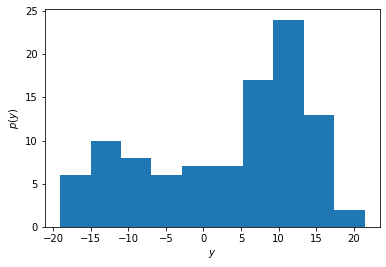

In [3]:
plt.hist(y)
plt.ylabel('$p(y)$')
plt.xlabel('$y$')
plt.show()

# MCMC

In [4]:
observations = y
k=2

In [42]:
MCMC_model = pm.Model()
with MCMC_model:
    #Parameters
    phi = pm.Dirichlet('phi',a=np.array([1., 1.]), shape=k)
    means = pm.Normal('means', mu=[-1,1], sigma=5, shape=k)
    
    sd = pm.Uniform('sd', lower=0, upper=20)
    
    z = pm.Categorical('z',p=phi, shape=N_SAMPLES)
    
    obs = pm.Normal('obs', 
                    mu=means[z], 
                    sigma=sd, 
                    observed=y)
    

In [43]:
with MCMC_model:  
    step1 = pm.Metropolis(vars=[phi, means])
    step2 = pm.ElemwiseCategorical(vars=[z], values=[0, 1])
    model_trace = pm.sample(N_SAMPLES, step=[step1, step2])
    

/Users/stuarttruax/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [phi]
>ElemwiseCategorical: [z]
>NUTS: [sd]
Sampling 4 chains: 100%|██████████| 2400/2400 [00:02<00:00, 975.37draws/s] 
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.10736146504189661, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


# Posterior Distributions

In [49]:
means_samples= model_trace["means"][N_SAMPLES:, None]
phi_samples= model_trace["phi"][N_SAMPLES:, None]
z_samples = model_trace["z"][N_SAMPLES:, None]
z_0_samples = model_trace["z"][N_SAMPLES:, 0]
z_10_samples = model_trace["z"][N_SAMPLES:, 10]

#print(means_samples.shape)
#print(means_samples)

mu_2_samples = model_trace["means"][N_SAMPLES:, 0]
mu_1_samples = model_trace["means"][N_SAMPLES:, 1]

print(mu_1_samples.mean())
print(mu_2_samples.mean())

print(z_samples)
print(z_0_samples)
print(z_10_samples)


2.915098503560765
-4.2965558978656535
[[[0 1 1 ... 0 1 1]]

 [[1 1 1 ... 0 1 1]]

 [[1 1 1 ... 0 0 1]]

 ...

 [[0 0 0 ... 1 1 0]]

 [[1 0 0 ... 1 0 0]]

 [[1 0 0 ... 1 1 0]]]
[0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0
 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1
 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0
 0 0 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 1
 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1
 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0
 1 0 1 1]
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1

Text(0, 0.5, 'Count')

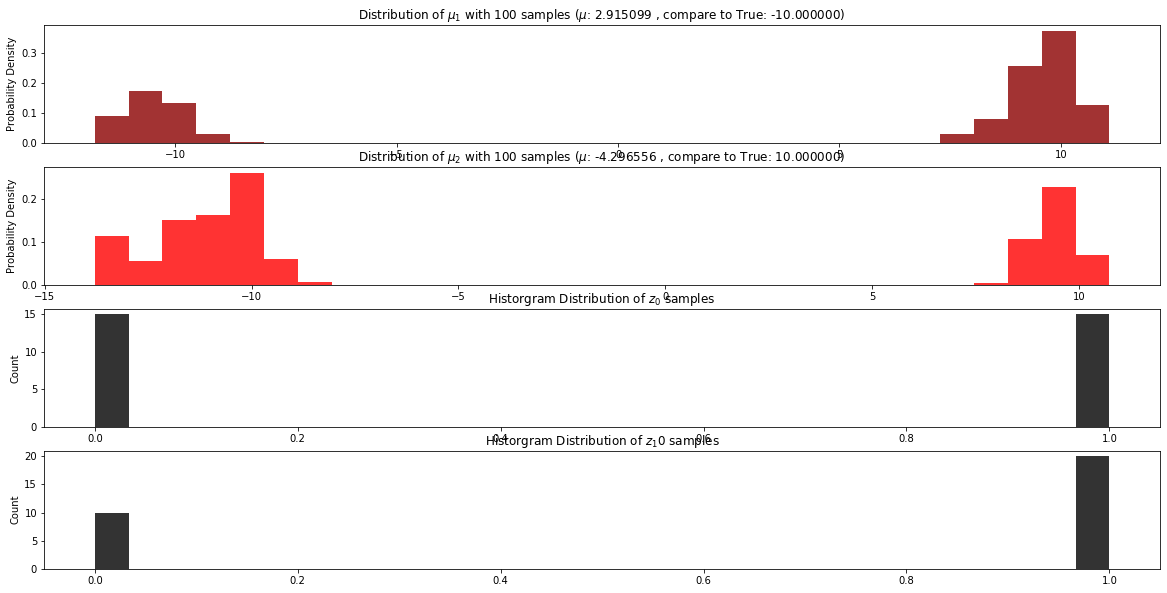

In [56]:
figsize(20, 10)

plt.subplot(411)
plt.title(r"""Distribution of $\mu_1$ with %d samples ($\mu$: %f , compare to True: %f)""" % (N_SAMPLES,mu_1_samples.mean(), mu_1_set))

plt.hist(mu_1_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(412)
plt.title(r"""Distribution of $\mu_2$ with %d samples ($\mu$: %f , compare to True: %f)""" % (N_SAMPLES,mu_2_samples.mean(),mu_2_set))

plt.hist(mu_2_samples, histtype='stepfilled', 
         color = 'red', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')

plt.subplot(413)
plt.title(r"""Historgram Distribution of $z_0$ samples""" )

plt.hist(z_0_samples, histtype='stepfilled', 
         color = 'black', bins=30, alpha=0.8, density=True);
plt.ylabel('Count')

plt.subplot(414)
plt.title(r"""Historgram Distribution of $z_10$ samples""" )

plt.hist(z_10_samples, histtype='stepfilled', 
         color = 'black', bins=30, alpha=0.8, density=True);
plt.ylabel('Count')
